In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=2)
%matplotlib inline

<font color='green'; size=4em>
Read the fraud data using Pandas
</font>

In [2]:
fraud_df = pd.read_csv('Candidate_tech_evaluation_candidate_copy_data science_fraud.csv',
                       header=0, 
                       index_col='Unnamed: 0')

In [3]:
def get_var_category(series):
    '''This function provides user readable values of the data types of a dataframe'''
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))

In [4]:
print_categories(fraud_df) 

user_id :  Numerical
signup_time :  Categorical
purchase_time :  Categorical
purchase_value :  Numerical
device_id :  Categorical
source :  Categorical
browser :  Categorical
sex :  Categorical
age :  Numerical
ip_address :  Numerical
class :  Numerical


<font color='green'; size=4em>
The timestamp columns are coming as categorical. Convert those to Date type.
</font>

In [5]:
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])

<font color='green'; size=4em>
Convert the class column to categorical.
</font>

In [6]:
fraud_df['class'] = fraud_df['class'].astype('category')

In [7]:
fraud_df['class'].value_counts()

0    108735
1     11265
Name: class, dtype: int64

<font color='green'; size=4em>
As expected, the classes are imbalanced. However, the imbalance is not as severe as to apply a class balancing algorithm. We may want to try applying it in the next steps to see if it helps.
</font>

<font color='green'; size=4em>
Read the IpAddress to Country dataset using Pandas and get field types
</font>

In [8]:
iptocountry_df = pd.read_excel('Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx',header=0)

In [9]:
print_categories(iptocountry_df)

lower_bound_ip_address :  Numerical
upper_bound_ip_address :  Numerical
country :  Categorical


<font color='green'; size=4em>
We can bring the country field from the IpAffress to Country dataset into the Fraud dataset by joining based on whether the IP address is between the lower and upper bound. Since Pandas merge and join methods don't allow conditional matching, we will have to revert to the apply method. Once, we join, we will substitute the null country fields with Unknown.
</font>

In [10]:
def find_country(ip):
    ''' Return country if the ip address falls between lower and upper bounds of a given country '''
    country =  iptocountry_df[(ip >= iptocountry_df['lower_bound_ip_address']) & 
                          (ip <= iptocountry_df['upper_bound_ip_address'])]['country']
    return None if country.empty else country.values[0]

In [11]:
fraud_df['country'] = fraud_df['ip_address'].apply(lambda ip: find_country(ip))

In [12]:
fraud_df.loc[fraud_df['country'].isnull(),'country'] = 'Unknown'

### EDA and Feature Engineering

<font color='green'; size=4em>
Let us first look at the purchase value.
</font>

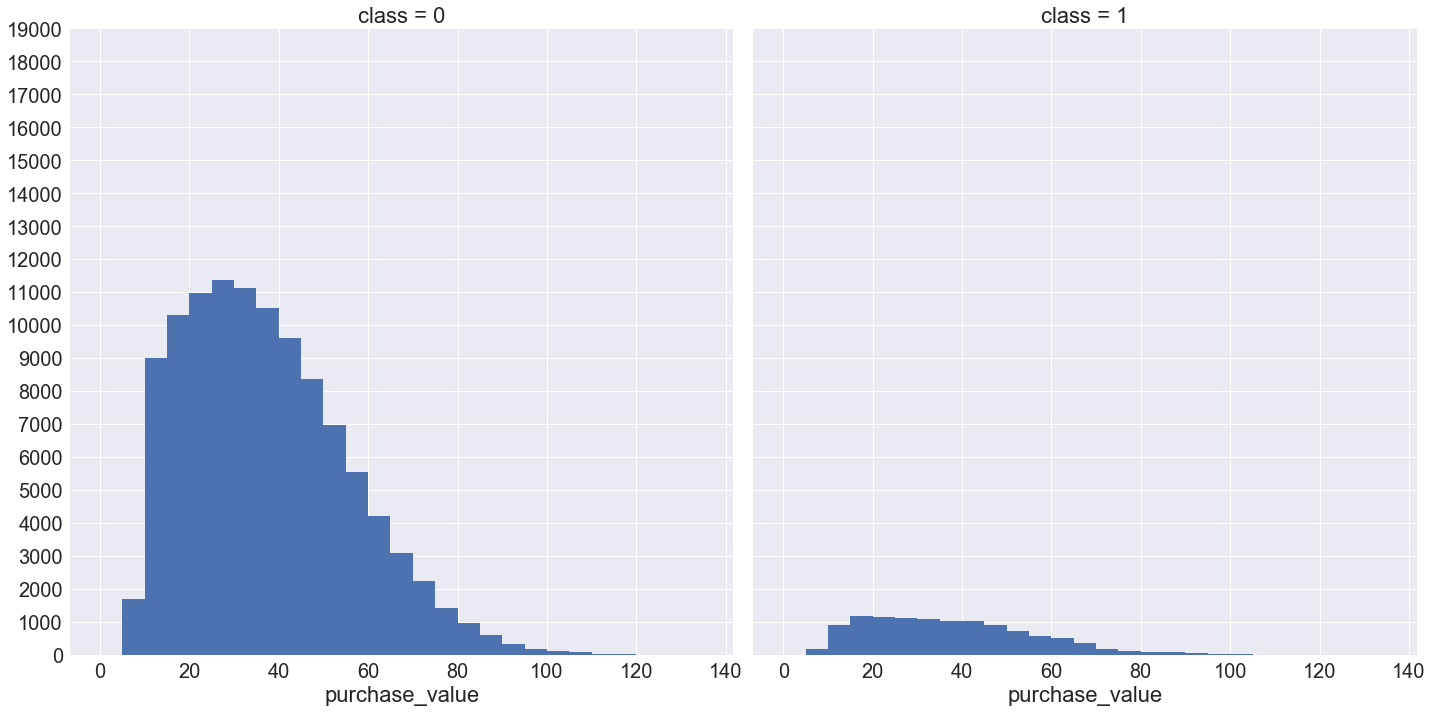

In [13]:
bins = np.arange(0, 140, 5)
g = sns.FacetGrid(fraud_df, col="class",size=10)
g = g.map(plt.hist, "purchase_value",bins=bins).set(yticks=np.arange(0,20000,1000))
g

<font color='green'; size=4em>
From the above plot, it appears that the fraudsters don't do big \$ transactions. This may be because small transactions are more likely to go unnoticed. 
For the transactions done by them, there appears to be a ceiling between \$100 and \$200.
</font>

<font color='green'; size=4em>
Let us look at the difference between the signup and purchase times. It is possible that fraudsters use some bot to signup right before making a purchase. We will convert the time difference to seconds to compare the classes.
</font>

In [14]:
fraud_df['diff_bet_signup_purchase'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).astype('timedelta64[s]')

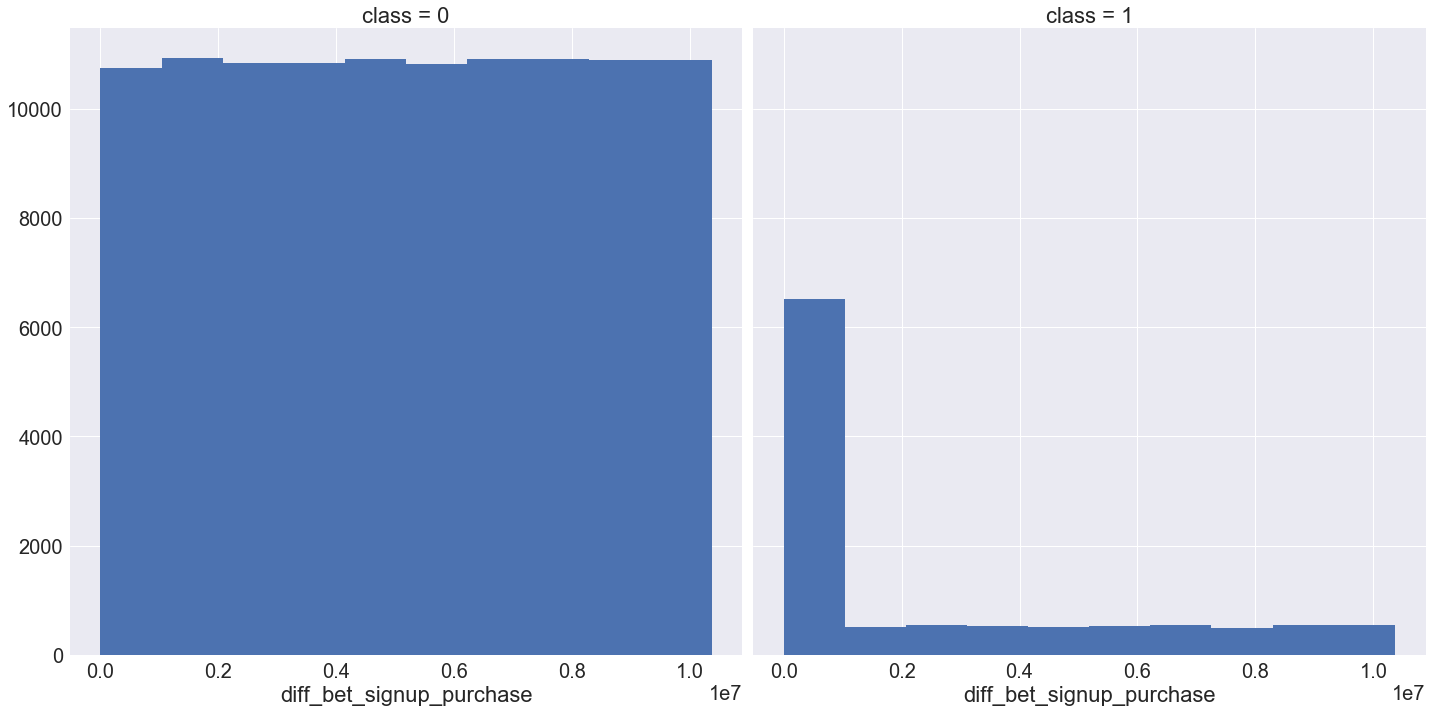

In [15]:
bins = np.arange(0, 20000, 10)
g = sns.FacetGrid(fraud_df, col="class",size=10)
g = g.map(plt.hist, "diff_bet_signup_purchase")
g

In [16]:
fraud_df['purchaseaftersignup_flag'] = np.where((fraud_df['diff_bet_signup_purchase'] >= 0) & 
                                                (fraud_df['diff_bet_signup_purchase'] <= 60), 1, 0)

In [17]:
pd.crosstab(fraud_df['purchaseaftersignup_flag'],fraud_df['class'])

class,0,1
purchaseaftersignup_flag,,
0,108735,5244
1,0,6021


<font color='green'; size=4em>
From the above visual, we can see that most fraud transactions are likely to happen in the first minute of the signup. To accomodate this behaviour, we created a variable called 'purchaseaftersignup_flag'.


Let us look at age now.
</font>

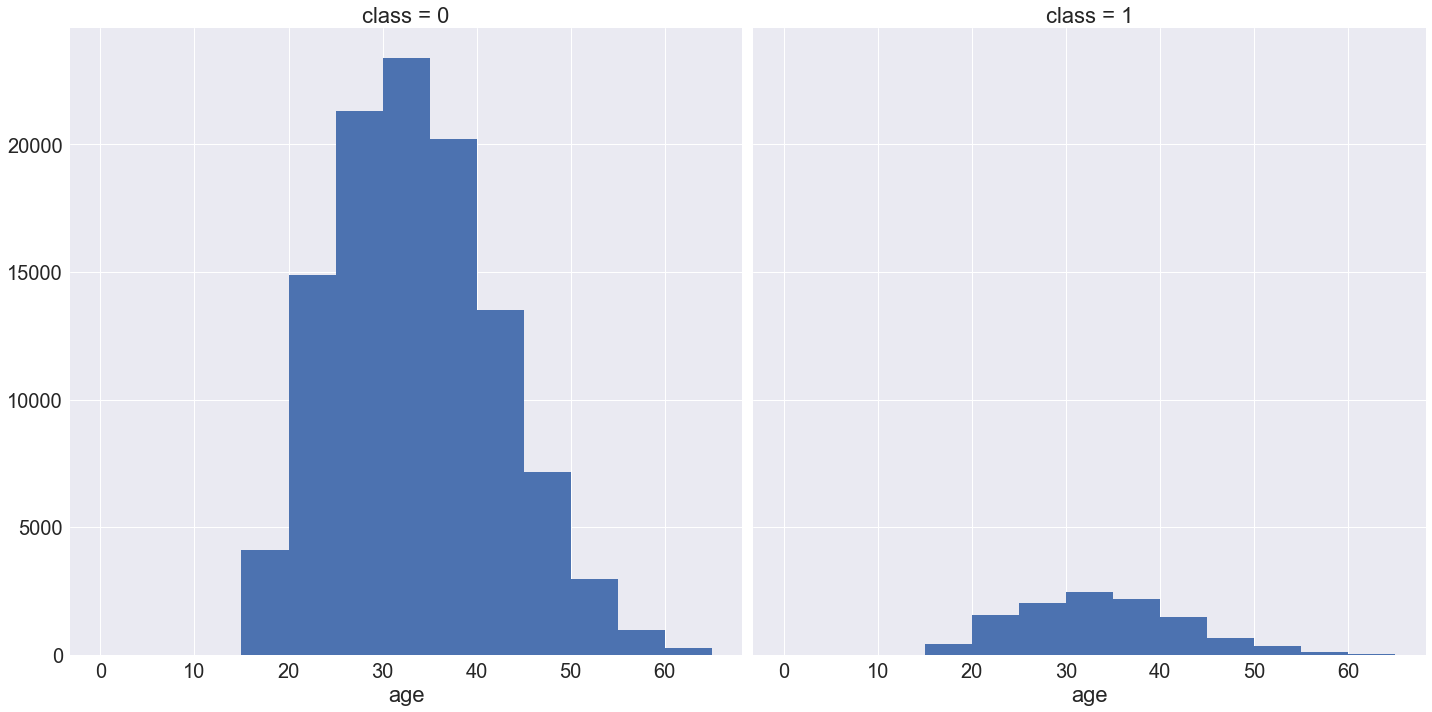

In [18]:
bins = np.arange(0, 70, 5)
g = sns.FacetGrid(fraud_df, col="class",size=10)
g = g.map(plt.hist, "age", bins=bins )
#.set(xlim=(0,175000),yticks=np.arange(0,6000,500))
g

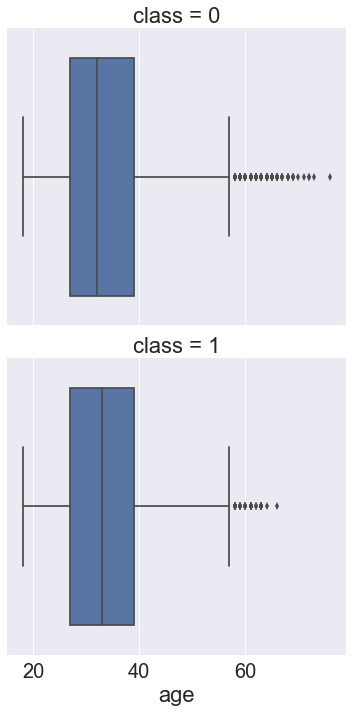

In [19]:
g = sns.FacetGrid(fraud_df, row="class",size=5)
g = g.map(sns.boxplot, "age", order=["0", "1"])

<font color='green'; size=4em>
From the above plots, for age we don't see a difference between the two groups (fraud vs. no-fraud) based on age. So, we are not sure whether this feature will make a difference in predicting fraud transactions.

Let us look at broswer variable.
</font>

In [20]:
pd.crosstab(fraud_df['browser'],fraud_df['class'],normalize='columns')*100

class,0,1
browser,,
Chrome,40.294293,42.947182
FireFox,16.341564,16.387040
IE,24.489815,22.272526
Opera,2.485860,2.414558
Safari,16.388467,15.978695


<font color='green'; size=4em>
    Certain small differences exist by browser. For example, Chrome is more used by fraudster whereas, IE is less likely used. Let us look at at source.
</font>

In [21]:
pd.crosstab(fraud_df['source'],fraud_df['class'],normalize='columns')*100

class,0,1
source,,
Ads,39.645928,38.632934
Direct,19.939302,22.734132
SEO,40.414770,38.632934


<font color='green'; size=4em>
As expected Direct channel is more widely used by fraudsters. Let us check on Gender next.
</font>

In [22]:
pd.crosstab(fraud_df['sex'],fraud_df['class'],normalize='columns')*100

class,0,1
sex,,
F,41.662758,40.585885
M,58.337242,59.414115


<font color='green'; size=4em>
    Slight differences by gender, but, not substantial.
</font>

In [23]:
def reset_index(df):
  '''Returns DataFrame with index as columns'''
  index_df = df.index.to_frame(index=False)
  df = df.reset_index(drop=True)
  #  In merge is important the order in which you pass the dataframes
  # if the index contains a Categorical. 
  # pd.merge(df, index_df, left_index=True, right_index=True) does not work
  return pd.merge(index_df, df, left_index=True, right_index=True)

<font color='green'; size=4em>
    Let us see whether differences by country exist. We will take columnwise proportions for each of class=0 and class=1, and find difference between the class percentages for each country.
</font>

In [24]:
country_df = reset_index(pd.crosstab(fraud_df['country'],fraud_df['class'],normalize='columns'))
country_df.columns = ['country','0','1']

In [25]:
country_df['difference'] = (country_df['1'] - country_df['0'])*100
country_df.sort_values(by='difference',ascending=False,inplace=True)
country_df.head(10)

,country,0,1,difference
166,United States,0.383612,0.396982,1.337027
30,Canada,0.019074,0.023968,0.489415
165,United Kingdom,0.029503,0.033023,0.351972
78,Ireland,0.001380,0.004172,0.279271
152,Sweden,0.006760,0.009498,0.273889
105,Mexico,0.007413,0.010031,0.261855
45,Denmark,0.002934,0.005504,0.257003
118,New Zealand,0.001609,0.004172,0.256280
140,Saudi Arabia,0.001582,0.003995,0.241285
74,India,0.008249,0.010386,0.213674


<font color='green'; size=4em>
    We can see that proportionally, more fraud transactions happen from the United States. So, we can leverage country as a feature in our models. Let us look at transaction count by device. As mentioned in the problem text, two transactions from the same device id means that same physical device was used to purchase. So, counting the number of transactions done from the device can help us in predicting fraud.
</font>

In [26]:
device_df = reset_index(pd.crosstab(fraud_df['device_id'],fraud_df['class']))
device_df.columns = ['device_id','0','1']
device_df['trancount'] = device_df['0'] + device_df['1']
device_df.sort_values(by='trancount',ascending=False,inplace=True)
device_df.head()

,device_id,0,1,trancount
37046,ITUMJCKWEYNDD,1,18,19
43705,KIPFSCNUGOLDP,1,16,17
19764,EQYVNEGOFLAWK,0,17,17
109743,ZUSVMDEZRBDTX,1,16,17
85930,UFBULQADXSSOG,2,14,16


<font color='green'; size=4em>
    As expected, we can see that fraudsters make a relatively large % of transactions from the same device. We can create a function to calculate count features for each of device id, country and ip_address.
</font>

In [27]:
# count # of transactions done from that device so far
def get_count(df,col):
    df.sort_values('purchase_time',ascending=True,inplace=True)
    temp = pd.DataFrame(df.groupby(col)['user_id'].count())
    temp.reset_index(inplace=True)
    colname = 'countoftranby_' + str(col)
    temp.rename(columns={'user_id':colname},inplace=True)
    df = df.merge(temp,on=col,how='left')
    return df

In [28]:
fraud_df = get_count(fraud_df,'device_id')
fraud_df = get_count(fraud_df,'country')
fraud_df = get_count(fraud_df,'ip_address')

<font color='green'; size=4em>
    Additional country logic
</font>

In [29]:
temp2 = pd.DataFrame(fraud_df.groupby('country')['user_id'].count())
temp2.reset_index(inplace=True)
colname = 'countoftranby_' + str('country')
temp2.rename(columns={'user_id':colname},inplace=True)

In [30]:
len(np.unique(fraud_df.loc[:,'country']))

177

In [31]:
len(np.unique(fraud_df.loc[fraud_df['countoftranby_country']<=100,'country']))

122

<font color='green'; size=4em>
    From the above, we can see that there are 177 countries in our dataset, but, 122 of them have 100 or fewer transactions coming from them. We can think of combining these countries to reduce dimensionality of our dataset.
</font>

In [32]:
def collapse_country(country):
    country = temp2[(temp2['country'] == country) & (temp2['countoftranby_country']>= 100)]
    return 'less_active' if country.empty else country['country'].values[0]

In [33]:
fraud_df['countrycollapsed'] = fraud_df['country'].apply(lambda country: collapse_country(country))

<font color='green'; size=4em>
    Date specific feature extraction.
</font>

In [34]:
def get_date_features(df):
    '''create features 'day_of_the_week, DOTW' and 'week_of_the_year, WOTY' from both signup and purchase dates.'''
    df['day_of_signup'] = pd.to_datetime(df['signup_time']).dt.day_name()
    df['day_of_purchase'] = pd.to_datetime(df['purchase_time']).dt.day_name()
    df['week_of_signup'] = pd.to_datetime(df['signup_time']).dt.weekofyear
    df['week_of_purchase'] = pd.to_datetime(df['purchase_time']).dt.weekofyear
    return df

In [35]:
fraud_df = get_date_features(fraud_df)

### Preprocessing

<font color='green'; size=4em>
    In the preprocessing section, we will encode categorical variables and generate numerical vectors that our models need.
</font>

In [36]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, auc, confusion_matrix

In [37]:
def labelencoding(df, col):
        le = preprocessing.LabelEncoder().fit(df[col])
        col_t = str(col) + '_le'
        df[col_t] = le.transform(df[col])
        return df

In [38]:
cols_to_encode = ['source','browser','sex','countrycollapsed','day_of_signup','day_of_purchase']
for col in cols_to_encode:
    fraud_df = labelencoding(fraud_df,col)

In [39]:
# drop unwanted columns
model_df = fraud_df[['purchase_value','purchaseaftersignup_flag','countoftranby_device_id','age',
                          'countoftranby_ip_address','source_le','browser_le','sex_le',
                         'countrycollapsed_le','day_of_signup_le','day_of_purchase_le','class']]

<font color='green'; size=4em>
    We have the model dataframe ready now.
</font>

### Modeling

<font color='green'; size=4em>
    We will build two types of modeling exercises. One is, we will apply a bunch of models from sklearn and find the best model. Next, we will use H2O Open source to develop a bunch of models using it/'s automated machine learning. One of the advantages of h2o based model is then run in parallel on a MapReduce or Spark cluster and can make scoring much faster. With Sklearn, it will be a single-threaded operation out of the box.
</font>

In [40]:
#train and test data split
def trainTestSplit(df, test_size, random_state):
    '''Split the dataframe into train and test return corresponding X and y variables.'''
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return x_train, x_test, y_train, y_test

In [41]:
def multi_modeling(x_train, y_train, x_test, y_test):
    '''This function will train a bunch of classifiers and returns their metrics'''
    metricsResults = []
    models = []
    tprResults = []
    fprResults = []
    predResults = []
    #classifiers = [rf, xgbc]
    classifiersName = ['MLP','DT CART', 'LDA',
                 #      'SVC (Linear kernal)',
                 #  'SVC (RBF)', 'SVC (Polynomial)', 
                       'Random Forest', 'k-Nearest Neigbors', 
                   'Naive Bayes (Gaussian)', 'Logistic Regression', 'xgboost']

    classifiers = [MLPClassifier(solver='lbfgs', alpha=1e-5, 
                             hidden_layer_sizes=(100, 100), random_state=1),
                DecisionTreeClassifier(criterion = 'entropy'),
                LinearDiscriminantAnalysis(n_components=50),
               #  svm.SVC(kernel='linear', C=1.0, tol=1e-3,probability=True),
               # svm.SVC(kernel='rbf', C=100.0, tol=1e-3,probability=True),
               # svm.SVC(kernel='poly', C=100.0, tol=1e-3, degree=2, coef0=100,probability=True),
                RandomForestClassifier(n_estimators=100, max_depth=5, criterion='gini', max_features='log2',
                                min_samples_split=3,random_state=0, n_jobs=-1),
                KNeighborsClassifier(n_neighbors=5),
                GaussianNB(),
                LogisticRegression(C=100.0),
                xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic',
                             booster='gbtree', reg_alpha=0, reg_lambda=1, random_state=0, n_jobs=4)]

    colnames = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'confusion_matrix']
    

    for i in range(len(classifiers)):
        metricsResult, model, pred, tpr, fpr = train_and_test_models(classifiers[i],x_train,y_train,x_test,y_test)
        metricsResults.append(metricsResult)
        models.append(model)
        predResults.append(pred)
        tprResults.append(tpr)
        fprResults.append(fpr)
        
    
    metricsResults = [item for sublist in metricsResults for item in sublist]
    metricsResults = pd.DataFrame({'Metrics': colnames, 
                                   '{}'.format(classifiersName[0]): metricsResults[0],
                                   '{}'.format(classifiersName[1]): metricsResults[1],
                                   '{}'.format(classifiersName[2]): metricsResults[2],
                                   '{}'.format(classifiersName[3]): metricsResults[3],
                                   '{}'.format(classifiersName[4]): metricsResults[4],
                                   '{}'.format(classifiersName[5]): metricsResults[5],
                                   '{}'.format(classifiersName[6]): metricsResults[6],
                                   '{}'.format(classifiersName[7]): metricsResults[7]
                                 })

    return metricsResults, models, predResults, tprResults, fprResults, classifiersName

In [42]:
def train_and_test_models(classifier,x_train,y_train,x_test,y_test):
    '''Takes a classifier as an arugment and returns metrics based on test data'''
    metrics = [] 
    model = classifier
    print (model)
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    y_hat_proba = model.predict_proba(x_test)[:, 1]
    tpr, fpr, thresholds = roc_curve(y_test, y_hat_proba)
    metrics.append((accuracy_score(y_test, y_hat), precision_score(y_test, y_hat), recall_score(y_test, y_hat),
             f1_score(y_test, y_hat), auc(tpr, fpr), confusion_matrix(y_test, y_hat)))
    #print (len(metrics))
    return (metrics, model, y_hat, tpr, fpr)

In [43]:
X_train, X_test, y_train, y_test = trainTestSplit(model_df, test_size=0.2, random_state=42)
metricsResults, models, predResults, tprResults, fprResults, classifierNames = multi_modeling(X_train, y_train, X_test, y_test)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
LinearDiscriminantAnalysis(n_components=50, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',

/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [44]:
metricsResults

,Metrics,MLP,DT CART,LDA,Random Forest,k-Nearest Neigbors,Naive Bayes (Gaussian),Logistic Regression,xgboost
0,accuracy,0.954375,0.912167,0.957583,0.957833,0.951292,0.952208,0.957333,0.957833
1,precision,0.935007,0.532391,0.993706,1,0.892045,0.899291,0.985992,1
2,recall,0.556973,0.596568,0.555653,0.554773,0.552574,0.557853,0.557413,0.554773
3,f1,0.698098,0.562656,0.712754,0.713639,0.682423,0.688569,0.712198,0.713639
4,auc,0.836544,0.770811,0.832664,0.830396,0.77949,0.830702,0.831556,0.835188
5,confusion_matrix,"[[21639, 88], [1007, 1266]]","[[20536, 1191], [917, 1356]]","[[21719, 8], [1010, 1263]]","[[21727, 0], [1012, 1261]]","[[21575, 152], [1017, 1256]]","[[21585, 142], [1005, 1268]]","[[21709, 18], [1006, 1267]]","[[21727, 0], [1012, 1261]]"


In [45]:
def plot_ROC(tpr, fpr, classifierNames):
    collist = ['g','b','r','y','k','w','m','c']
    plt.figure(figsize=(16, 16))
    plt.plot([0, 1], [0, 1], c='k', linestyle='--')
    for i in range(len(classifierNames)):
        lab = str(classifierNames[i]) + ' AUC: {:.4f}'
        plt.plot(tpr[i], fpr[i], label=lab.format(auc(tpr[i], fpr[i])), c=collist[i], linestyle='-')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Fraud detection - ROC')
    plt.legend(loc='lower right')
    plt.plot()      

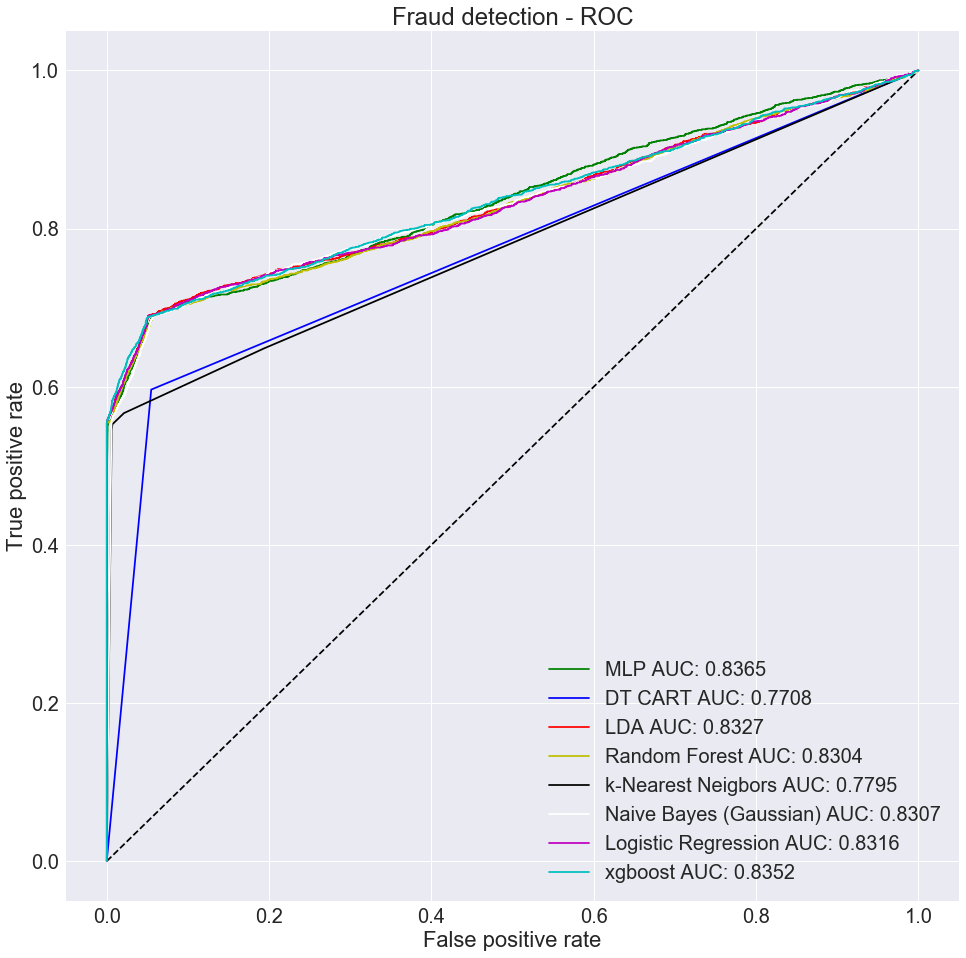

In [46]:
plot_ROC(tprResults, fprResults,classifierNames)

<font color='green'; size=4em>
    Based on the above, it appears that Multi Layered Perceptron and Xgboost models seem to have the highest AUC on a test dataset. Given that xgboost is more versatile with features of various types, we will consider Xgboost as our best model coming out of sklearn. One thing to note, is Logistic Regression is performing relatively well. Given that logistic regression is a much faster model, we can consider it as well if speed is a criterion.
</font>

<font color='green'; size=4em>
    H2O is another versatile open source tool that allows deploying models that can run on JVMs. We will use automl method from this tool to provide the best model. We will run H2O in the local mode.
</font>

In [47]:
import h2o
from h2o.automl import H2OAutoML

In [48]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "9.0.4"; Java(TM) SE Runtime Environment (build 9.0.4+11); Java HotSpot(TM) 64-Bit Server VM (build 9.0.4+11, mixed mode)
  Starting server from /Users/amit.dingare/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/hr/kpq5k_jx70v7k54z6kc8lqw832_twp/T/tmpjwptfx_p
  JVM stdout: /var/folders/hr/kpq5k_jx70v7k54z6kc8lqw832_twp/T/tmpjwptfx_p/h2o_amit_dingare_started_from_python.out
  JVM stderr: /var/folders/hr/kpq5k_jx70v7k54z6kc8lqw832_twp/T/tmpjwptfx_p/h2o_amit_dingare_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_amit_dingare_1rwycy
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [49]:
h2o_model_df = h2o.H2OFrame(model_df)
# Split the data into Train/Test/Validation with Train having 80% and test having 20%
train,test = h2o_model_df.split_frame(ratios = [.8], seed = 1234)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [50]:
# Identify predictors and response
X = train.columns
y = "class"
X.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [51]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=X, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()  # Print all rows instead of default (10 rows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_1_AutoML_20190127_192651,0.832267,0.164023,0.230974,0.198574,0.0394316
XGBoost_2_AutoML_20190127_192651,0.832116,0.16312,0.228333,0.198204,0.039285
XGBoost_3_AutoML_20190127_192651,0.831419,0.163328,0.227318,0.198162,0.0392683
StackedEnsemble_BestOfFamily_AutoML_20190127_192651,0.830996,0.162851,0.230974,0.198628,0.0394532
DeepLearning_grid_1_AutoML_20190127_192651_model_1,0.830994,0.171602,0.231095,0.201772,0.0407121
GBM_4_AutoML_20190127_192651,0.830045,0.166221,0.230974,0.199659,0.0398639
GLM_grid_1_AutoML_20190127_192651_model_1,0.829968,0.166409,0.230896,0.19942,0.0397685
XGBoost_grid_1_AutoML_20190127_192651_model_3,0.829842,0.162006,0.230383,0.19761,0.0390496
GBM_5_AutoML_20190127_192651,0.829793,0.166899,0.230471,0.199032,0.0396139
GBM_2_AutoML_20190127_192651,0.82963,0.163232,0.230704,0.198337,0.0393374


In [52]:
# Predict
best_model = aml.leader
preds = best_model.predict(test)
predictions = preds.as_data_frame(use_pandas=True)

deeplearning prediction progress: |███████████████████████████████████████| 100%


<font color='green'; size=4em>
    From the above, Xgboost seems to have the best AUC immediately followed by the Deep Learning (Multi-Layered Perceptron). The results are quite similar to what we got out of the sklearn model. One of the advantages of H2O is, creating stacked ensemble models is easy. Let us see how the stacked ensemble model for this use case performs. 
</font>

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20190127_192651


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.03914000727267829
RMSE: 0.1978383362057978
LogLoss: 0.1618665603499201
Null degrees of freedom: 95942
Residual degrees of freedom: 95934
Null deviance: 59730.10798656997
Residual deviance: 31059.92679930477
AIC: 31077.92679930477
AUC: 0.8307112306086413
pr_auc: 0.17069145936307767
Gini: 0.6614224612172825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4088349404715522: 


,0,1,Error,Rate
0,86810.0,132.0,0.0015,(132.0/86942.0)
1,4079.0,4922.0,0.4532,(4079.0/9001.0)
Total,90889.0,5054.0,0.0439,(4211.0/95943.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4088349,0.7003913,47.0
max f2,0.1004467,0.6633433,290.0
max f0point5,0.9992562,0.8534522,0.0
max accuracy,0.9992562,0.9566618,0.0
max precision,0.9992562,1.0,0.0
max recall,0.0307513,1.0,398.0
max specificity,0.9992562,1.0,0.0
max absolute_mcc,0.9992562,0.7165846,0.0
max min_per_class_accuracy,0.0347838,0.7492501,351.0
max mean_per_class_accuracy,0.1004467,0.8176601,290.0


Gains/Lift Table: Avg response rate:  9.38 %, avg score:  9.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100059,0.9992596,10.6591490,10.6591490,1.0,0.9992664,1.0,0.9992664,0.1066548,0.1066548,965.9148983,965.9148983
,2,0.0200015,0.9992556,10.6591490,10.6591490,1.0,0.9992571,1.0,0.9992617,0.1065437,0.2131985,965.9148983,965.9148983
,3,0.0300074,0.9992539,10.6591490,10.6591490,1.0,0.9992546,1.0,0.9992593,0.1066548,0.3198533,965.9148983,965.9148983
,4,0.0400029,0.9992527,10.6591490,10.6591490,1.0,0.9992533,1.0,0.9992578,0.1065437,0.4263971,965.9148983,965.9148983
,5,0.0500089,0.9992415,10.6591490,10.6591490,1.0,0.9992509,1.0,0.9992565,0.1066548,0.5330519,965.9148983,965.9148983
,6,0.1000073,0.1606261,2.6331231,6.6465543,0.2470294,0.2454987,0.6235539,0.6224169,0.1316520,0.6647039,163.3123107,564.6554285
,7,0.1500057,0.0358463,0.6621694,4.6518979,0.0621222,0.0570930,0.4364230,0.4339887,0.0331074,0.6978114,-33.7830645,365.1897913
,8,0.2000042,0.0352563,0.3910799,3.5867489,0.0366896,0.0355122,0.3364949,0.3343748,0.0195534,0.7173647,-60.8920112,258.6748918
,9,0.3000010,0.0346878,0.3621933,2.5119344,0.0339796,0.0349428,0.2356599,0.2345676,0.0362182,0.7535829,-63.7806695,151.1934390
,10,0.3999979,0.0343232,0.3588602,1.9736799,0.0336669,0.0344973,0.1851630,0.1845513,0.0358849,0.7894678,-64.1139762,97.3679878




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.039164245970038626
RMSE: 0.19789958557318563
LogLoss: 0.16196247183471366
Null degrees of freedom: 95942
Residual degrees of freedom: 95935
Null deviance: 59732.721746148585
Residual deviance: 31078.330870475867
AIC: 31094.330870475867
AUC: 0.8291617310911942
pr_auc: 0.3911256683688768
Gini: 0.6583234621823884
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41036270005883807: 


,0,1,Error,Rate
0,86812.0,130.0,0.0015,(130.0/86942.0)
1,4085.0,4916.0,0.4538,(4085.0/9001.0)
Total,90897.0,5046.0,0.0439,(4215.0/95943.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4103627,0.6999359,44.0
max f2,0.0988989,0.6633433,301.0
max f0point5,0.9991410,0.8534522,1.0
max accuracy,0.9991410,0.9566618,1.0
max precision,0.9992528,1.0,0.0
max recall,0.0306827,1.0,398.0
max specificity,0.9992528,1.0,0.0
max absolute_mcc,0.9991410,0.7165846,1.0
max min_per_class_accuracy,0.0349540,0.7476947,359.0
max mean_per_class_accuracy,0.0988989,0.8176601,301.0


Gains/Lift Table: Avg response rate:  9.38 %, avg score:  9.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100059,0.9992607,10.6591490,10.6591490,1.0,0.9992826,1.0,0.9992826,0.1066548,0.1066548,965.9148983,965.9148983
,2,0.0200015,0.9992266,10.6591490,10.6591490,1.0,0.9992523,1.0,0.9992675,0.1065437,0.2131985,965.9148983,965.9148983
,3,0.0300074,0.9991769,10.6591490,10.6591490,1.0,0.9992212,1.0,0.9992520,0.1066548,0.3198533,965.9148983,965.9148983
,4,0.0400029,0.9991402,10.6591490,10.6591490,1.0,0.9991497,1.0,0.9992264,0.1065437,0.4263971,965.9148983,965.9148983
,5,0.0500089,0.9991253,10.6591490,10.6591490,1.0,0.9991324,1.0,0.9992076,0.1066548,0.5330519,965.9148983,965.9148983
,6,0.1000073,0.1596631,2.6153467,6.6376670,0.2453617,0.2445446,0.6227202,0.6219154,0.1307632,0.6638151,161.5346749,563.7667032
,7,0.1500057,0.0361045,0.7154984,4.6637480,0.0671253,0.0571251,0.4375347,0.4336651,0.0357738,0.6995889,-28.4501569,366.3747995
,8,0.2000042,0.0354575,0.2999761,3.5728619,0.0281426,0.0357352,0.3351920,0.3341878,0.0149983,0.7145873,-70.0023950,257.2861862
,9,0.3000010,0.0348354,0.3733035,2.5063795,0.0350219,0.0351120,0.2351388,0.2344993,0.0373292,0.7519165,-62.6696471,150.6379471
,10,0.3999979,0.0344274,0.3366398,1.9639587,0.0315822,0.0346203,0.1842510,0.1845309,0.0336629,0.7855794,-66.3360210,96.3958685



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9559933,0.0004818,0.95542,0.9558916,0.9563105,0.9552192,0.9571257
auc,0.8298517,0.0034086,0.8328497,0.8375792,0.8266765,0.8281858,0.8239673
err,0.0440066,0.0004818,0.0445800,0.0441085,0.0436896,0.0447808,0.0428743
err_count,844.4,8.597674,855.0,849.0,845.0,852.0,821.0
f0point5,0.8390274,0.0085035,0.8477107,0.8197485,0.8502024,0.8300493,0.8474261
---,---,---,---,---,---,---,---
r2,0.5392020,0.0069264,0.5416086,0.5550571,0.5327378,0.5407600,0.5258468
recall,0.5516565,0.0149975,0.5506465,0.5863409,0.5339967,0.5610433,0.5262551
residual_deviance,6215.666,77.909035,6321.411,6028.9116,6333.598,6202.1714,6192.2383
rmse,0.1978909,0.0014173,0.2001671,0.1942602,0.1990382,0.1984343,0.1975544



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2019-01-27 20:04:14,0.000 sec,0,29865.0539934,0.3112791
,2019-01-27 20:04:14,0.044 sec,1,15929.9102198,0.1667855
,2019-01-27 20:04:14,0.067 sec,2,15536.5964725,0.1625656
,2019-01-27 20:04:14,0.090 sec,3,15529.9853255,0.1625039
,2019-01-27 20:04:14,0.112 sec,4,15529.9633997,0.1625039


Metalearner model is :


/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


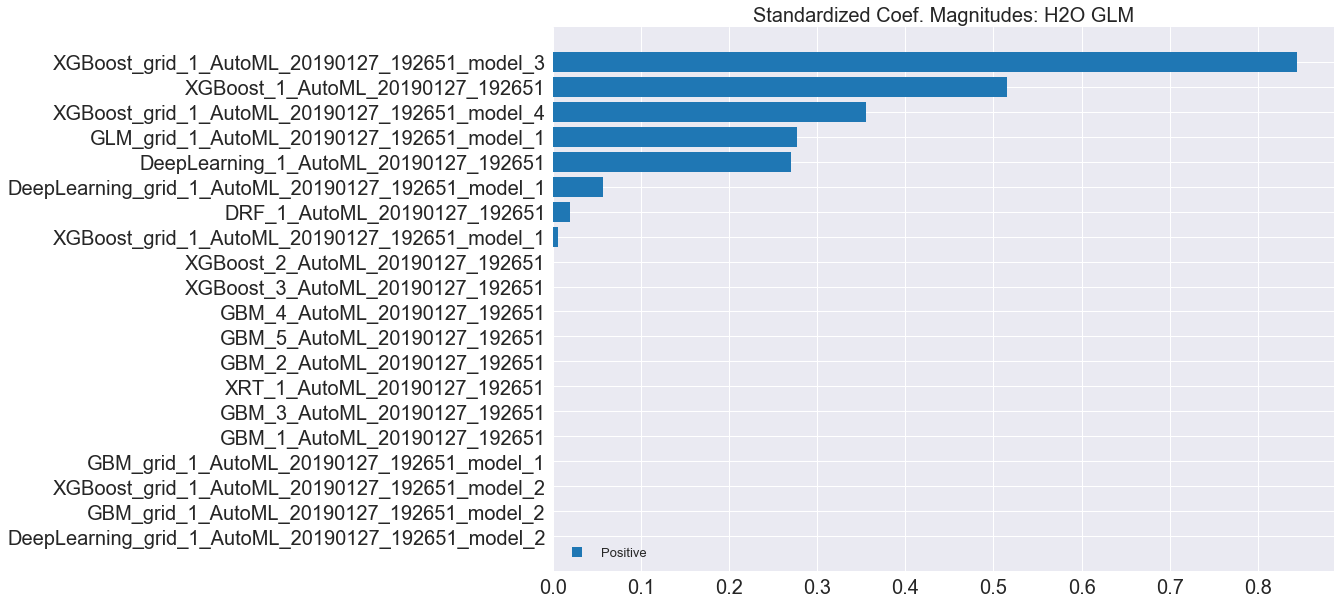

In [53]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])
print ("Metalearner model is :{}".format(metalearner))
metalearner.std_coef_plot()

<font color='green'; size=4em>
   Let us see the performance of the best H2O model on the test data. We will H2O functions first followed by sklearn function. 
</font>

In [54]:
best_model.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.04199164399269619
RMSE: 0.20491862773475766
LogLoss: 0.18372159508836108
Mean Per-Class Error: 0.1949175984313698
AUC: 0.8162267919530034
pr_auc: 0.16698868304530315
Gini: 0.6324535839060068
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6478775964871473: 


,0,1,Error,Rate
0,21793.0,0.0,0.0,(0.0/21793.0)
1,1083.0,1181.0,0.4784,(1083.0/2264.0)
Total,22876.0,1181.0,0.045,(1083.0/24057.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6478776,0.6856313,4.0
max f2,0.0597032,0.6418629,205.0
max f0point5,0.6478776,0.8450200,4.0
max accuracy,0.6478776,0.9549819,4.0
max precision,0.9999971,1.0,0.0
max recall,0.0041299,1.0,396.0
max specificity,0.9999971,1.0,0.0
max absolute_mcc,0.6478776,0.7049449,4.0
max min_per_class_accuracy,0.0162841,0.7349823,274.0
max mean_per_class_accuracy,0.0290079,0.8050824,216.0


Gains/Lift Table: Avg response rate:  9.41 %, avg score:  6.94 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100594,1.0000000,10.6258834,10.6258834,1.0,1.0000000,1.0,1.0000000,0.1068905,0.1068905,962.5883392,962.5883392
,2,0.0200357,1.0000000,10.6258834,10.6258834,1.0,1.0000000,1.0,1.0000000,0.1060071,0.2128975,962.5883392,962.5883392
,3,0.0300536,0.9999999,10.6258834,10.6258834,1.0,0.9999999,1.0,1.0000000,0.1064488,0.3193463,962.5883392,962.5883392
,4,0.0401131,0.9999993,10.6258834,10.6258834,1.0,0.9999997,1.0,0.9999999,0.1068905,0.4262367,962.5883392,962.5883392
,5,0.0500062,0.2042451,9.7775986,10.4580598,0.9201681,0.9400516,0.9842062,0.9881398,0.0967314,0.5229682,877.7598584,945.8059798
,6,0.1000125,0.1063665,2.3583631,6.4082115,0.2219451,0.1438136,0.6030756,0.5659767,0.1179329,0.6409011,135.8363147,540.8211472
,7,0.1500187,0.0191589,0.6447959,4.4870730,0.0606816,0.0311220,0.4222776,0.3876918,0.0322438,0.6731449,-35.5204083,348.7072954
,8,0.2000249,0.0179086,0.4151426,3.4690904,0.0390690,0.0184780,0.3264755,0.2953883,0.0207597,0.6939046,-58.4857424,246.9090359
,9,0.2999958,0.0163465,0.3976422,2.4455580,0.0374220,0.0170720,0.2301510,0.2026419,0.0397527,0.7336572,-60.2357794,144.5558032
,10,0.4000083,0.0151603,0.3621457,1.9246508,0.0340815,0.0157352,0.1811285,0.1559104,0.0362191,0.7698763,-63.7854348,92.4650811


In [55]:
#Here we evaluate the model
import sklearn
from sklearn import metrics
test_df = test.as_data_frame(use_pandas=True)
test_df
y_test = test_df["class"]
predictions = predictions.values[:,2]
predictions
sklearn.metrics.roc_auc_score(y_test, predictions)

0.816260872254666

<font color='green'; size=4em>
    Sklearn shows the same AUC as h2o model performance function.
</font>

<font color='blue'; size=4em>
    <b>
    Given the simplicity associated with deploying H2O models, we will consider the best H2O AutoML model named "XGBoost_grid_1_AutoML_20190127_141419_model_3", our final model.
    </b>
</font>

### Next Steps

<font color='green'; size=4em>
    <b>
    - Class balancing using various techniques.
    </b>
    
    <br>
    In this case, given the ratio of positive classes to negative classes, we didn't balance classes. However, we could try doing so to see it improves performance.
    </br>
</font>

<font color='green'; size=4em>
    <b>
    - Adding new features.
    </b>    
    <br>
    Given the time we had to complete this project, we didn't try additional feature creation. Using the dataset, we could create time specific features to see if frauds are likely to happen at certain time of the day. Several other features could be created by adding external datasets such as IP to zip mapping and then leveraging Experian report of internet frauds by zipcode. Another way could be the company can start capturing zip code of the location where the order was asked to be shipped. In the future, the fraudsters are going to be sophisticated and may use technologies such as VPN to hide tracing them. In such a case, Electronica needs to stay ahead of the competition. Electronica could employ streaming fraud analytics to minimize losses resulting from fraudulant transactions.
    </br>
</font>

In [56]:
#fraud_df['cumcountoftran'] = fraud_df.groupby('device_id').cumcount()+1

In [57]:
# Get the average purchase price of fraud transaction
fraud_df[fraud_df['class']==1]['purchase_value'].mean()

37.066134043497556

In [58]:
# Get the average purchase price of fraud transaction
fraud_df[fraud_df['class']==0]['purchase_value'].mean()

36.862344231388235

 <font color='green'; size=4em>
    <b>
        - Business valuation in setting thresholds.
    </b>
    
    <br>
    In solving the above problem, we treated both false positives and false negatives to be of equal importance. However, in real life, each of these two have a different cost associated with it. Each of the false positive has a cost of \$8 (it inconveniences the Electronica customers whose valid transactions are flagged). The cost of false negative is \$37 as shown above. The valu of the True positive is also ~\$37 and the value of the true negative is same as cost of the false negative. Using the above numbers, we can develop a better threshold from a business value perspective rather than relying solely on best AUC thresholds.
    </br>
</font>
    